#**IMPORT DELLE LIBRERIE E CARICAMENTO DEL DATASET**


In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.tv_tensors import BoundingBoxes, BoundingBoxFormat, Mask
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import random
import pycocotools
from pycocotools import mask
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.autograd import Variable
from PIL import Image
TRAIN_DIR = '/content/drive/MyDrive/trainingset'
AUG_TRAIN_DIR = '/content/drive/MyDrive/trainset_aug'
TEST_DIR = '/content/drive/MyDrive/testset'
TRAIN_LABELS = '/content/drive/MyDrive/train.json'
AUG_TRAIN_LABELS = '/content/drive/MyDrive/train_aug.json'
TEST_LABELS =  '/content/drive/MyDrive/test.json'
IM_WIDTH = 700
IM_HEIGHT = 700
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Per prima cosa definiamo alcune funzione che serviranno a formattare opportunamente le etichette per essere utilizzate dai modelli:

1.   ***groupByImageId:*** raggruppa le etichette in base all'image_id, in modo che il dataset sarà formato dalle coppie <immagine, lista_annotazioni_immagine>
2.   ***decodeSegmentationField:*** trasforma la maschera contenuta nel json sotto forma di dato poligonale in una maschera binaria della stessa shape dell'immagine
3.   ***formatLabels:*** formatta la lista delle etichette di una immagine in modo che sia un dizionario della forma:


```
      {
        'boxes': tensore di box in formato xyxy
        'labels': tensore delle etichette di classe (incrementate di 1)
        'image_id': id immagine
        'iscrowd': valore booleano
        'area': tensore delle aree
        'masks': tensore di maschere binarie
      }
```
  è inoltre importante osservare che andiamo a incrementare di +1 i valori relativi alle etichette di classe, questo si rende necessario in quanto il modello che andremo a utilizzare di seguito Mask R-CNN codifica con il valore 0 la classe "background" e quindi questo valore non può codificare altre classi











In [3]:
def groupByImageId(jsonfile):
  data = jsonfile['annotations']
  labs = {}
  for k in data:
    if k['image_id'] in labs:
      labs[k['image_id']].append(k)
    else:
      labs[k['image_id']] = [k]
  return labs

In [4]:
def decodeSegmentationField(segmentation):
  return mask.decode(mask.merge(mask.frPyObjects(segmentation,IM_WIDTH,IM_HEIGHT))) if type(segmentation) == list else mask.decode(segmentation)

In [5]:
def formatLabels(labels):
  bbox = []
  seg = []
  cls = []
  i = 0
  for label in labels:
    seg.append(decodeSegmentationField(label['segmentation']))
    b = label['bbox']
    box = [b[0],b[1],b[0]+b[2], b[1]+b[3]]
    if(box[2]-box[0] <= 0):
      box[2]+=1
    if(box[3]-box[1] <= 0):
      box[3]+=1
    bbox.append(box)
    i+=1
    cls.append(label['category_id']+1)
  return  {
      'boxes': torchvision.tv_tensors.BoundingBoxes(data=np.array(bbox),format = BoundingBoxFormat.XYXY, canvas_size=(IM_WIDTH, IM_HEIGHT)),
      'labels': torch.tensor(cls, dtype = torch.int64),
      'image_id': label['image_id'],
      'area': torch.tensor(label['area'], dtype=torch.float64),
      'iscrowd': torch.tensor(label['iscrowd'], dtype=torch.uint8),
      'masks': Mask(seg)
  }

A questo punto definiamo la morfologia del dataset attraverso una classe apposita "PowerLineDataset" che costruisce il Dataset come un insieme di coppie (immagine, dizionario) nel formato sopra descritto.

In [6]:
class PowerLineDataset(torch.utils.data.Dataset):
  def __init__(self,img_dir,img_labels):
    self.img_dir = img_dir
    self.img_labels = json.load(open(img_labels))
    self.categories = {} #lista delle etichette di classe
    for c in self.img_labels['categories']:
      self.categories[c['name']] = c['id']+1 #incrementiamo di uno per distinguere la background class

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.img_labels['images'][idx]['file_name'])
    label = groupByImageId(self.img_labels)[idx]
    image = (torchvision.io.read_image(img_path)/255)
    return (image,formatLabels(label))
  def __len__(self):
    return len(os.listdir(self.img_dir))


###***DATA AUGMENTATION***

Al fine di rendere il modello più prestante proviamo a ottenere dei nuovi dati partendo da quelli che già abbiamo. Per fare Data Augmentation si possono applicare diverse trasformazioni: sia geometriche che di intensità. In questo caso, al fine di rendere semplice l'etichettatura delle immagini trasformate utilizzaremo una trasformazione di intensità (le cui etichette rimangono uguali a quelle dell'immagine originale) e una trasformazione geometrica, la rotazione, in quanto una volta applicata all'immagine, le etichette dell'immagine ruotata si possono ottenere applicando la stessa trasformazione anche ai tensori delle maschere e da queste ricavare i box.

per prima cosa andiamo a creare una nuova directory per preservare i dati reali, questa directory conterrà sia i dati reali che quelli generati tramite trasformazione

In [ ]:
!rm //content//drive//MyDrive//trainset_aug//*.jpg

In [ ]:
!mkdir //content//drive//MyDrive//trainset_aug

In [ ]:
!cp //content//drive//MyDrive//trainingset//*.jpg //content//drive//MyDrive//trainset_aug

Di seguito andiamo a campionare randomicamente un numero di immagini del training set regolato dal parametro "max_id" e per ciascuna immagine creiamo una copia, con un nuovo id, a cui è stata applicata una transformazione selezionata randomicamente tra le 2 viste sopra, nel caso della rotazione anche l'angolo di rotazione viene selezionato casualmente in accordo ad una distribuzione uniforme nel range [30,350]. Inoltre replichiamo le annotazioni dell'immagine di partenza (eventualmente trasformate a loro volta) e andando a sostituire l'image_id con quello della nuova immagine e assegnando un nuovo annotation_id

In [ ]:
def rotateMask(ann,angle):
  ann = torch.tensor(decodeSegmentationField(ann))
  ann = torchvision.transforms.functional.rotate(ann.reshape(1,700,700), angle)
  ann = ann.reshape((700,700))
  rle = pycocotools.mask.encode(np.asfortranarray(ann.numpy().astype(np.uint8)))
  rle['counts'] = rle['counts'].decode('ascii')
  return rle

def applyRotation(label, image_id, ann_id, angle):
  masks = rotateMask(label['segmentation'],angle)
  m = torch.tensor(decodeSegmentationField(masks))
  bbox = torchvision.ops.masks_to_boxes(masks=m.reshape((1, 700,700))) if torch.max(m)>0 else None
  if bbox == None:
    return None
  else:
    assert len(bbox.squeeze_().tolist()) == 4
    return {
        'segmentation': masks,
        'iscrowd':label['iscrowd'],
        'area':label['area'],
        'image_id':image_id,
        'category_id': label['category_id'],
        'id': ann_id,
        'bbox': bbox.squeeze_().tolist()
    }

def applyColorJitter(label, image_id,ann_id):
  return{
        'segmentation': label['segmentation'],
        'iscrowd': label['iscrowd'],
        'area':label['area'],
        'image_id':image_id,
        'bbox': label['bbox'],
        'category_id':label['category_id'],
        'id':ann_id
    }

In [ ]:
f = json.load(open(TRAIN_LABELS))
next_id= np.max([ann['image_id'] for ann in f['annotations']])+1
next_ann_id = np.max([ann['id'] for ann in f['annotations']])+1
max_id = 100 #numero di nuove immagini da inserire
anns = groupByImageId(f)
images = f['images']
cats = f['categories']
nanns = f['annotations']
for id in range(next_id,next_id+max_id):
  rand = np.random.randint(low=0,high=next_id-1)
  choice = np.random.random()
  colorjitter = torchvision.transforms.ColorJitter(brightness=0.3,contrast=0.3,hue=0.3,saturation=0.3)
  image = Image.open(os.path.join(TRAIN_DIR,images[rand]['file_name']))
  angle = np.random.randint(low=30, high=350)
  image = colorjitter(image) if choice<=0.5 else torchvision.transforms.functional.rotate(image, angle)
  image.save(os.path.join(AUG_TRAIN_DIR,'aug_{}'.format(images[rand]['file_name'])))
  l = list(zip(anns[rand], range(next_ann_id,next_ann_id+len(anns[rand]))))
  for (ann, ann_id) in l:
    if choice <= 0.5:
      nanns.append(applyColorJitter(ann,id,ann_id))
    else:
      a = None
      while(a == None):
        angle = np.random.randint(low=30, high=350)
        a = applyRotation(ann,id,ann_id,angle)
      nanns.append(a)
  images.append({
       'height': IM_HEIGHT,
      'width': IM_WIDTH,
       'id':id,
       'file_name': 'aug_{}'.format(images[rand]['file_name'])
   })
  next_ann_id += len(anns[rand])

result = {
    'images':images,
    'categories':cats,
    'annotations':nanns
}
with open(AUG_TRAIN_LABELS,'w') as fp:
  json.dump(result,fp)

In [23]:
def load_dataset(augmentation = True):
  return PowerLineDataset(img_dir=AUG_TRAIN_DIR, img_labels=AUG_TRAIN_LABELS) if augmentation else PowerLineDataset(TRAIN_DIR, TRAIN_LABELS)
trainset = load_dataset()
test = PowerLineDataset(TEST_DIR, TEST_LABELS)

#**TEST DI UN MODELLO PREADDESTRATO: MASK R-CNN**

Andiamo di seguito a effettuare una fase di fine tuning su un modello Mask R-CNN preaddestrato sul dataset MS-COCO. In particolare usiamo un modello Mask R-CNN che migliora le prestazione del modello Mask R-CNN base utilizzando come backbone un modello Vision Transformer secondo quando descritto all'interno del paper https://arxiv.org/abs/2111.11429.

##***CARICAMENTO DEL MODELLO***

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_V2_Weights,progress=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Tuttavia il modello così come viene fornito non può essere utilizzato per i nostri scopi in quanto le teste di classificazione che utilizzano fanno riferimento al dataset MS-COCO che contiene circa 80 classi diverse mentre noi necessitiamo di un modello che funzioni su 5 classi (4 nel dataset + il background). Pertanto decidiamo di sostituire la testa della rete in modo che sia conforme al numero di classi nel nostro dataset

In [ ]:
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=5)

In [2]:
#spostiamo tutti i tensori sul device selezionato
def targetsToDevice(targets, device):
  return [{
      'boxes': target['boxes'].to(device),
      'labels': target['labels'].to(device),
      'image_id': target['image_id'],
      'area': target['area'].to(device),
      'iscrowd':target['boxes'].to(device),
      'masks': target['masks'].to(device)
  } for target in targets]

#***VT***

In [2]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Union
from torchvision.models.detection.faster_rcnn import _default_anchorgen,TwoMLPHead,AnchorGenerator
from torchvision.models.detection.rpn import RPNHead,RegionProposalNetwork
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection.mask_rcnn import MaskRCNNHeads, MaskRCNNPredictor
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.models.detection.transform import GeneralizedRCNNTransform

In [3]:
class MyNet(nn.Module):
  def __init__(
        self,
        backbone,
        training=True,
        num_classes=None,
        # transform parameters
        min_size=800,
        max_size=1333,
        image_mean=None,
        image_std=None,
        # RPN parameters
        rpn_anchor_generator=None,
        rpn_head=None,
        rpn_pre_nms_top_n_train=2000,
        rpn_pre_nms_top_n_test=1000,
        rpn_post_nms_top_n_train=2000,
        rpn_post_nms_top_n_test=1000,
        rpn_nms_thresh=0.7,
        rpn_fg_iou_thresh=0.7,
        rpn_bg_iou_thresh=0.3,
        rpn_batch_size_per_image=256,
        rpn_positive_fraction=0.5,
        rpn_score_thresh=0.0,
        # Box parameters
        box_roi_pool=None,
        box_head=None,
        box_predictor=None,
        box_score_thresh=0.05,
        box_nms_thresh=0.5,
        box_detections_per_img=100,
        box_fg_iou_thresh=0.5,
        box_bg_iou_thresh=0.5,
        box_batch_size_per_image=512,
        box_positive_fraction=0.25,
        bbox_reg_weights=None,
        **kwargs,
    ):
    super(MyNet,self).__init__()
    self.backbone = backbone
    self.training=training
    out_channels = backbone.out_channels
    anchor_sizes = ((784,3072),(392,1536),(196,768),(98,384))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    rpn_anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)
    rpn_head = RPNHead(out_channels, rpn_anchor_generator.num_anchors_per_location()[0])
    rpn_pre_nms_top_n = dict(training=rpn_pre_nms_top_n_train, testing=rpn_pre_nms_top_n_test)
    rpn_post_nms_top_n = dict(training=rpn_post_nms_top_n_train, testing=rpn_post_nms_top_n_test)
    self.rpn = RegionProposalNetwork(
          rpn_anchor_generator,
          rpn_head,
          rpn_fg_iou_thresh,
          rpn_bg_iou_thresh,
          rpn_batch_size_per_image,
          rpn_positive_fraction,
          rpn_pre_nms_top_n,
          rpn_post_nms_top_n,
          rpn_nms_thresh,
          score_thresh=rpn_score_thresh,
      )
    box_roi_pool = MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"], output_size=7,sampling_ratio=2)
    resolution = box_roi_pool.output_size[0]
    representation_size = 1024
    box_head = TwoMLPHead(out_channels * resolution**2, representation_size)
    box_predictor = FastRCNNPredictor(representation_size, num_classes)
    mask_roi_pool = MultiScaleRoIAlign(featmap_names=["0", "1", "2", "3"], output_size=14, sampling_ratio=2)
    mask_layers = (256, 256, 256, 256)
    mask_dilation = 1
    mask_head = MaskRCNNHeads(out_channels, mask_layers, mask_dilation)
    mask_predictor_in_channels = 256
    mask_dim_reduced = 256
    mask_predictor = MaskRCNNPredictor(mask_predictor_in_channels, mask_dim_reduced, num_classes)
    self.roi_heads = RoIHeads(
            # Box
            box_roi_pool,
            box_head,
            box_predictor,
            box_fg_iou_thresh,
            box_bg_iou_thresh,
            box_batch_size_per_image,
            box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh,
            box_nms_thresh,
            box_detections_per_img,
        )
    image_mean = [0.485, 0.456, 0.406]
    image_std = [0.229, 0.224, 0.225]
    self.transform = GeneralizedRCNNTransform(min_size, max_size, image_mean, image_std, **kwargs)
    self.roi_heads.mask_roi_pool = mask_roi_pool
    self.roi_heads.mask_head = mask_head
    self.roi_heads.mask_predictor = mask_predictor

  def forward(self, images, targets=None):
     original_image_sizes: List[Tuple[int, int]] = []
     for img in images:
          val = img.shape[-2:]
          torch._assert(
              len(val) == 2,
              f"expecting the last two dimensions of the Tensor to be H and W instead got {img.shape[-2:]}",
          )
          original_image_sizes.append((val[0], val[1]))

     images, targets = self.transform(images, targets)
     if targets is not None:
            for target_idx, target in enumerate(targets):
                boxes = target["boxes"]
                degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
                if degenerate_boxes.any():
                    # print the first degenerate box
                    bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                    degen_bb: List[float] = boxes[bb_idx].tolist()
                    torch._assert(
                        False,
                        "All bounding boxes should have positive height and width."
                        f" Found invalid box {degen_bb} for target at index {target_idx}.",
                    )

     features = self.backbone(images.tensors)
     if isinstance(features, torch.Tensor):
          features = OrderedDict([("0", features)])
     proposals, proposal_losses = self.rpn(images, features, targets)
     detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)
     detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]

     losses = {}
     losses.update(detector_losses)
     losses.update(proposal_losses)
     if self.training:
      return losses
     else:
      return detections


In [4]:
class VTBackbone(nn.Module):
  def __init__(self,out_features):
    super(VTBackbone,self).__init__()
    self.out_channels = out_features
    self.vt = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights)
    self.vt.heads=nn.Sequential()
    #rendiamo parte dei layer non addestrabili
    self.vt.conv_proj.requires_grad_(False)
    self.vt.encoder.layers.encoder_layer_0.requires_grad_(False)
    self.vt.encoder.layers.encoder_layer_1.requires_grad_(False)
    self.vt.encoder.layers.encoder_layer_2.requires_grad_(False)
    self.vt.encoder.layers.encoder_layer_3.requires_grad_(False)
    self.vt.encoder.layers.encoder_layer_4.requires_grad_(False)
    self.vt.encoder.layers.encoder_layer_5.requires_grad_(False)
    self.adp = nn.AdaptiveMaxPool2d(output_size=(224,224))
    self.fpn = torchvision.ops.FeaturePyramidNetwork([256,256,256,256], 5)
    self.up1 = nn.Sequential(
        nn.ConvTranspose2d(in_channels = 1,out_channels=128,kernel_size=2,stride = 2),
        nn.GroupNorm(num_groups=1, num_channels=128),
        nn.GELU(),
        nn.ConvTranspose2d(in_channels=128, out_channels=256,kernel_size=2,stride=2)
    )
    self.up2=nn.ConvTranspose2d(in_channels = 1,out_channels=256,kernel_size=2,stride = 2)
    self.ds = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=256,kernel_size=5, padding='same'),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv3=nn.Conv2d(in_channels=1,out_channels=256,kernel_size=5, padding='same')

  def forward(self,x):
    x = self.adp(x)
    x = self.vt._process_input(x)
    x = x + self.vt.encoder.pos_embedding[0][:-1]
    x = self.vt.encoder.dropout(x)
    x0 = self.vt.encoder.layers.encoder_layer_0(x)
    x1 = self.vt.encoder.layers.encoder_layer_1(x0)
    x2 = self.vt.encoder.layers.encoder_layer_2(x1)
    x3 = self.vt.encoder.layers.encoder_layer_3(x2)
    x4 = self.vt.encoder.layers.encoder_layer_4(x3)
    x5 = self.vt.encoder.layers.encoder_layer_5(x4)
    x6 = self.vt.encoder.layers.encoder_layer_6(x5)
    x7 = self.vt.encoder.layers.encoder_layer_7(x6)
    x8 = self.vt.encoder.layers.encoder_layer_8(x7)
    x9 = self.vt.encoder.layers.encoder_layer_9(x8)
    x10 = self.vt.encoder.layers.encoder_layer_10(x9)
    x11 = self.vt.encoder.layers.encoder_layer_11(x10)
    ln = self.vt.encoder.ln(x11)
    res = OrderedDict()
    x3 = self.up1(x3.unsqueeze_(dim=0))
    x6 = self.up2(x6.unsqueeze(dim=0))
    x9 = self.conv3(x9.unsqueeze_(dim=0))
    ln = self.ds(ln.unsqueeze(dim=0))
    res['0'] = x3
    res['1'] = x6
    res['2'] = x9
    res['3'] = ln
    res = self.fpn(res)
    return res



In [5]:
model = MyNet(backbone=VTBackbone(out_features = 5),num_classes = 5,device=device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
t = torch.randn((1,3,700,700))
model.eval()
model(t)

[{'boxes': tensor([[5.7255e+02, 2.8102e+01, 6.9962e+02, 1.9964e+02],
          [5.7313e+02, 1.0916e+02, 6.9998e+02, 2.8020e+02],
          [2.0988e+02, 1.4045e-01, 6.9005e+02, 2.3503e+02],
          [2.1431e+02, 1.1421e+02, 3.9160e+02, 2.7972e+02],
          [4.9635e+01, 0.0000e+00, 1.1156e+02, 8.0930e+01],
          [3.0535e+02, 8.0143e+01, 4.2707e+02, 3.1774e+02],
          [4.5565e+00, 1.9339e+02, 4.0448e+02, 4.3006e+02],
          [4.2089e+00, 2.7699e+02, 3.2081e+02, 5.1343e+02],
          [4.3725e+00, 4.5168e+02, 3.2085e+02, 6.8911e+02],
          [0.0000e+00, 2.3529e+01, 4.0256e+02, 2.5729e+02],
          [2.4390e+02, 1.5604e+01, 3.6309e+02, 2.5880e+02],
          [5.7360e+02, 9.6528e-01, 6.9988e+02, 1.0044e+02],
          [0.0000e+00, 3.4543e+02, 4.5345e+02, 5.7722e+02],
          [3.3315e+00, 3.6749e+02, 3.2036e+02, 6.0456e+02],
          [0.0000e+00, 5.1859e+02, 2.6312e+02, 7.0000e+02],
          [3.2596e+02, 3.9397e+00, 6.9808e+02, 3.6391e+02],
          [2.4089e+02, 2.3828e+

##***MODEL TRAINING***

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

Manteniamo la batch size limitata per evitare che sia necessaria una quantità di memoria troppo elevata e procediamo ad effettuare il fine tuning del modello eseguendo 36 epoche di addestramento

In [ ]:
model.train()
model.to(device)
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 1
trains = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True,collate_fn= collate_fn)
total_step = len(trains)

num_epochs = 200

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trains) for i in range(num_epochs + 1)]


def train(epoch,model,optimizer):
    l=[]
    for batch_idx, (images, targets) in enumerate(trains):

        images = [image.to(device) for image in images]
        targets = targetsToDevice(targets,device)
        # Forward pass
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        #backward pass
        losses.backward()
        optimizer.step()
        l.append(losses.item())
        torch.cuda.empty_cache()
        #if (batch_idx+1) % 1 == 0:
        #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        #           .format(epoch, num_epochs, batch_idx+1, total_step, losses))

        train_losses.append(losses)
        train_counter.append(
        (batch_idx*batch_size) + ((epoch-1)*len(trains)))
    print('Epoch [{}/{}] loss (mean): {:.4f}'.format(epoch,num_epochs,np.mean(l)))

In [ ]:
e = 0
for epoch in range(149,num_epochs+1):
  train(epoch=epoch,
        model = model, optimizer = optimizer)
  e+=1
  if e%1==0 or epoch == num_epochs:
    torch.save(model, '/content/drive/MyDrive/maskrcnn_vt_{}ep'.format(epoch))
    e=0

/usr/local/lib/python3.10/dist-packages/torchvision/tv_tensors/_tv_tensor.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.as_tensor(data, dtype=dtype, device=device).requires_grad_(requires_grad)


##***MODEL EVALUATION***

Procediamo con la valutazione del modello su cui è stato effettuato il fine tuning per il task in esame

In [13]:
#carichiamo il modello addestrato su 36 epoche
torch.cuda.empty_cache()
model = torch.load('/content/drive/MyDrive/maskrcnn_vt_160ep',map_location=device)

In [ ]:
torch.save(model, '/content/drive/MyDrive/maskrcnn_vt_v3_2ep'.format(epoch))

NameError: name 'torch' is not defined

In [17]:
#GENERAZIONE DEL FILE JSON IN FORMATO COCO
model.eval()
batch_size = 1
testloader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False, collate_fn = collate_fn)

results = []
j = 0
for idx, (images, targets) in enumerate(testloader):

  prediction = model([image.to(device) for image in images])[0]
  classes = prediction['labels'].cpu().numpy()
  scores = prediction['scores'].cpu().detach().numpy()
  boxes = prediction['boxes'].view(-1,4).cpu().detach().numpy()
  masks = prediction['masks'].view(-1,IM_HEIGHT,IM_WIDTH).cpu().detach()
  masks = torch.where(masks>0.5,1,0).numpy()
  #controllare shape
  for i in range(masks.shape[0]):
    image_id = targets[0]['image_id']
    bbox = [boxes[i][0],boxes[i][1],boxes[i][2]-boxes[i][0],boxes[i][3]-boxes[i][1]]
    bbox = [round(float(x)*10)/10 for x in bbox]
    rle = pycocotools.mask.encode(np.asfortranarray(masks[i].astype(np.uint8)))
    rle['counts'] = rle['counts'].decode('ascii')
    j+=1
    results.append({
                'image_id': int(image_id),
                'category_id': int(classes[i])-1,
                'bbox': bbox,
                'segmentation': rle,
                'score': float(scores[i]),
                'area': bbox[2]*bbox[3],
                'height': IM_HEIGHT,
                'width': IM_WIDTH,
                'id':j
            })

  torch.cuda.empty_cache()
with open('/content/drive/MyDrive/pred.json', 'w') as fp:
    json.dump(results, fp)


/usr/local/lib/python3.10/dist-packages/torchvision/tv_tensors/_tv_tensor.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.as_tensor(data, dtype=dtype, device=device).requires_grad_(requires_grad)


In [18]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
test = '/content/drive/MyDrive/test.json'
pred = '/content/drive/MyDrive/pred.json'
gt = COCO(test)
detections = gt.loadRes(pred)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!


In [19]:
imgIds=sorted(gt.getImgIds())
imgId = imgIds[np.random.randint(100)]

In [21]:
annType = 'bbox'
cocoEval = COCOeval(gt, detections, annType)
cocoEval.params.imgIds = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.66s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.044
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.059
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [22]:
annType = 'segm'
cocoEval = COCOeval(gt, detections, annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=1.53s).
Accumulating evaluation results...
DONE (t=0.13s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.023
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [25]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
def visualize(img, model, view_boxes = True, view_masks = True):
  prediction = model([img])
  im = torch.tensor((img*255).cpu().numpy().astype(np.uint8),dtype=torch.uint8)
  result = im
  if view_boxes:
    result = draw_bounding_boxes(image=im,boxes=prediction[0]['boxes'],width=3)
  if view_masks:
    masks=torch.squeeze(prediction[0]['masks'])
    masks = torch.where(masks>0.5,True,False)
    result = draw_segmentation_masks(image = result,masks=masks,alpha=0.5)
  return result

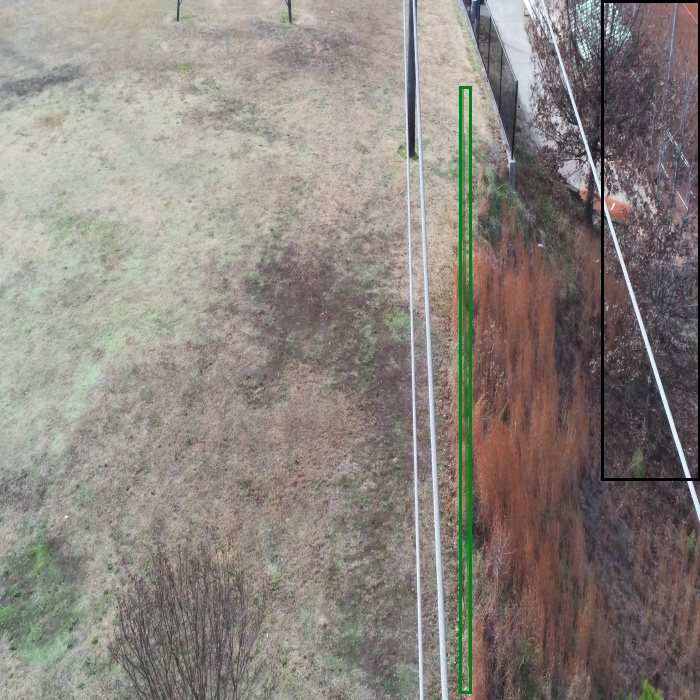

In [37]:
model.eval()
i = np.random.randint(0,len(test)-1)
r = visualize(test[i][0].to(device),model)
torchvision.transforms.ToPILImage()(r)

In [ ]:
def cocoEvaluation(imgIds,annType):
  cocoEval = COCOeval(gt, detections, annType)
  cocoEval.params.imgIds  = imgIds
  cocoEval.evaluate()
  cocoEval.accumulate()
  cocoEval.summarize()

def buildPredictionFile(model_file, file_name):
  model = torch.load(model_file,map_location=device)
  model.eval()
  batch_size = 1
  testloader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False, collate_fn = collate_fn)

  results = []
  j = 0
  for idx, (images, targets) in enumerate(testloader):

    prediction = model([image.to(device) for image in images])[0]
    classes = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().detach().numpy()
    boxes = prediction['boxes'].view(-1,4).cpu().detach().numpy()
    masks = prediction['masks'].view(-1,IM_HEIGHT,IM_WIDTH).cpu().detach()
    masks = torch.where(masks>0.5,1,0).numpy()
    for i in range(masks.shape[0]):
      image_id = targets[0]['image_id']
      bbox = [boxes[i][0],boxes[i][1],boxes[i][2]-boxes[i][0],boxes[i][3]-boxes[i][1]]
      bbox = [round(float(x)*10)/10 for x in bbox]
      rle = pycocotools.mask.encode(np.asfortranarray(masks[i].astype(np.uint8)))
      rle['counts'] = rle['counts'].decode('ascii')
      j+=1
      results.append({
                  'image_id': int(image_id),
                  'category_id': int(classes[i])-1,
                  'bbox': bbox,
                  'segmentation': rle,
                  'score': float(scores[i]),
                  'area': bbox[2]*bbox[3],
                  'height': IM_HEIGHT,
                  'width': IM_WIDTH,
                  'id':j
              })

    torch.cuda.empty_cache()
  with open(file_name, 'w') as fp:
      json.dump(results, fp)

def evaluate(pred_name, test_name):
  gt = COCO(test_name)
  detections = gt.loadRes(pred_name)
  imgIds=sorted(gt.getImgIds())
  print('\n--------------- BOX EVALUATION ---------------\n\n')
  cocoEvaluation(imgIds,'bbox')
  print('\n--------------- SEGMENTATION EVALUATION ---------------\n\n')
  cocoEvaluation(imgIds,'segm')


In [ ]:
names = [
    ('/content/drive/MyDrive/maskrcnn_28ep_augmentation','/content/drive/MyDrive/maskrcnn_28ep'),
     ('/content/drive/MyDrive/maskrcnn_33ep_augmentation','/content/drive/MyDrive/maskrcnn_33ep'),
    ('/content/drive/MyDrive/maskrcnn_36ep_augmentation','/content/drive/MyDrive/maskrcnn_36ep'),
    ('/content/drive/MyDrive/maskrcnn_36ep_no_augmentation','/content/drive/MyDrive/maskrcnn_36ep_noaug')
    ]

for f,mod in names:
  torch.cuda.empty_cache()
  test = PowerLineDataset(TEST_DIR, TEST_LABELS)
  buildPredictionFile(mod,f)
  print(f, ' generated...')

/content/drive/MyDrive/maskrcnn_28ep_augmentation  generated...
/content/drive/MyDrive/maskrcnn_33ep_augmentation  generated...
/content/drive/MyDrive/maskrcnn_36ep_augmentation  generated...
/content/drive/MyDrive/maskrcnn_36ep_no_augmentation  generated...
